# Should I try and join the NBA?

I put my skills to the test. On a cold and windy day with a deflated ball that I grabbed before I knew it was flat, I headed to the courts in a public park in my hometown to test my basketball skills. My test consisted of $40$ trials: Each trial consisted of $5$ shots from the same spot and the same shooting pattern. The data that I recorded from each trial was the following:
 - How many shots I made:
 - How far from the net I was: $0$ being close up, $1$ being midrange, and $2$ being far away
 - My orientation: $0$ being on the left side of the net, $1$ being straight on, and $2$ being the right side
 
Let's take a look!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Here's the data:

In [2]:

shots = { '# Made': [4,3,3,1,1,1,3,2,1,3,0,0,1,4,1,5,3,3,0,1,5,4,3,1,1,1,3,1,2,1,1,2,2,3,5,3,2,0,0,2],
       'Orientation': [1,0,2,1,1,1,2,0,0,2,1,0,2,1,1,1,2,0,0,2,1,2,0,0,2,0,2,0,1,1,2,2,2,0,1,2,1,1,0,0],
        'Distance' : [0,0,0,1,1,1,1,1,1,1,2,2,2,1,1,0,0,0,2,2,0,0,0,1,1,1,1,2,2,1,2,1,1,0,0,0,1,2,2,1]}

df = pd.DataFrame(shots)
df.index = ['Trial #' + str(i+1) for i in range(40)]

Here's the first 5 trials:


In [3]:
df.head()

,# Made,Orientation,Distance
Trial #1,4,1,0
Trial #2,3,0,0
Trial #3,3,2,0
Trial #4,1,1,1
Trial #5,1,1,1


Here's the last 5 trials: So for instance, in trial #37, I made 2 out of 5 shots from midrange and straight on.

In [4]:
df.tail()

,# Made,Orientation,Distance
Trial #36,3,2,0
Trial #37,2,1,1
Trial #38,0,1,2
Trial #39,0,0,2
Trial #40,2,0,1


Here's how many shots I made out of 200 total...

In [5]:
print(df['# Made'].sum())

82


In other words, my overall shooting percentage is...

In [6]:
str(df['# Made'].sum() / 2) + '%'

'41.0%'

Maybe I got better though as the number of trials went on? Let's look at a graph of the Trial # (x-axis) vs. # of Shots Made (y-axis)

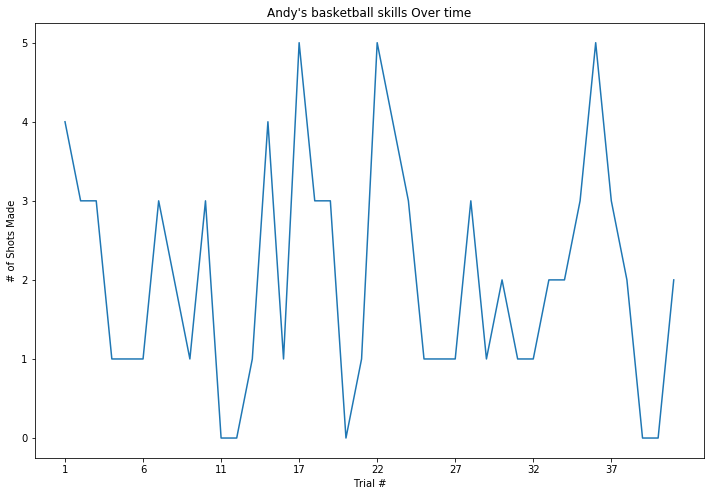

In [7]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df['# Made'])
plt.title("Andy's basketball skills Over time")
plt.xlabel("Trial #")
plt.ylabel("# of Shots Made")
plt.xticks(np.arange(0,40,step=5),('1','6','11',17,22,27,32,37))
plt.show()

Doesn't look like I got better over time... but before you give up on me, let's keep in mind that I switched up how far from the basket I was when I shot the ball over my different trials. Also, I had the flu. The larger the dot in the above scatter plot, the further away I shot the ball from the net. With that in mind, let's break down how I shot the ball over time from fixed distances:

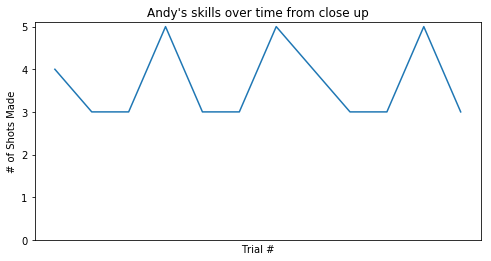

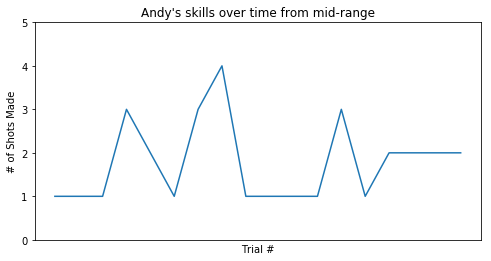

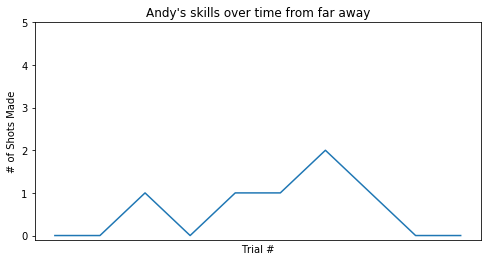

In [19]:
distance_dict = {0: 'close up', 1:'mid-range', 2:'far away'}
df.index = np.arange(1,41)
for i in [0,1,2]:
    plt.figure(i,figsize=(8,4))
    size = len(df[df['Distance']==i].index)
    plt.plot(range(1,size+1), df[df['Distance']==i]['# Made'])
    plt.title("Andy's skills over time from " + str(distance_dict[i]))
    plt.ylabel("# of Shots Made")
    plt.xlabel("Trial #")
    plt.yticks(np.arange(0,6))
    plt.xticks(())

Well, ok, so it doesn't look like I got better over time, even if I separate by distance, but it does look like my distance from the net is associated with how many shots I made. Let's confirm this:

Text(0.5,1,'Distance vs. # Made')

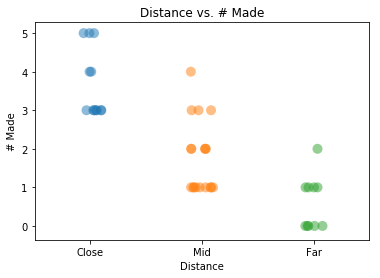

In [9]:
graph1 = sns.stripplot(x='Distance', y='# Made', data=df, jitter=True,size = 10,alpha=0.5)
graph1.set_xticklabels(['Close','Mid','Far'])
graph1.set_title('Distance vs. # Made')

Indeed... there is a negative correlation between distance and # of shots made, but this is unsurprising, since the same is true for many other NBA players. How about orientation though? Does that play a role in how well I shot the ball? As in, if I shot from the left side, straight on, or right side of the basket - does that have anything to do with how many shots I made?

Text(0.5,1,'Orientation vs. # Made')

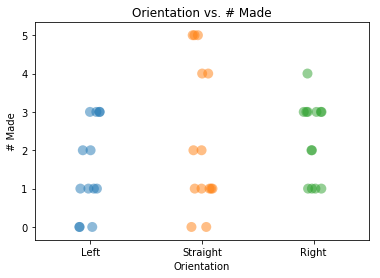

In [10]:
graph2 = sns.stripplot(x='Orientation', y='# Made', data=df, jitter=True,size = 10,alpha=0.5)
graph2.set_xticklabels(['Left','Straight','Right'])
graph2.set_title('Orientation vs. # Made')

Looks like I shot the best from straight on, a little worse from the right side, and even worse from the left side. However, I'm not sure if I shot the ball from the left, straight on, and from the right the same number of times.. let's see:

In [11]:
orientation_dict = {0: 'the left side', 1: 'straight on', 2: 'the right side'}
for i in [0,1,2]:
    print('# of times I shot the ball from ' + str(orientation_dict[i]) + ':',  len(df[df['Orientation']==i])   )

# of times I shot the ball from the left side: 13
# of times I shot the ball from straight on: 14
# of times I shot the ball from the right side: 13


# kNN classification
Here's my question now... if I know how far away I shot the ball (close, midrange, or far away), and I know the number of shots I made (0 through 5), am I able to detect on which side of the net I shot the ball on (left, straight, or right side)? To investigate this, I'm going to try using a kNN-classifier. First, let's split up the data into $70\%$ training data, and $30\%$ test data.

In [12]:
X = df.drop(['Orientation'],axis=1)
y = df['Orientation']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)


I'm going to try and implement kNN here from scratch. Let's see... first thing I'll need is a distance function.

In [13]:
def distance(lst1,lst2):
    dist = 0
    L = len(lst1)
    for i in range(L):
        dist += abs(lst1[i] - lst2[i])**2
    return np.sqrt(dist)

I only have two features here (the number of shots I make, and the distance from the net), meaning that for a given point in $\mathbb{R}^{2}$, I'd like to find the nearest $k$ points in my training data to the given point.

In [14]:
def FindkNearestNeighbors(point, training_data,k):
    j = k
    while True:
        distances_from_testpoint = {}
        for i in np.array(training_data.index):
            distances_from_testpoint[i] = distance(tuple(training_data.loc[i]), point)
        list_of_distances = sorted(distances_from_testpoint, key=distances_from_testpoint.__getitem__)[:j]
        if distances_from_testpoint[list_of_distances[-1]] in sorted(distances_from_testpoint.values())[j:]:
            if j > 1:
                j -= 1
            elif j == 1:
                return mode([ y_train.loc[i] for i in list_of_distances])
        else:
            try:
                return mode([ y_train.loc[i] for i in list_of_distances])
            except ValueError:
                j -=1

Lastly, I'd like to predict the appropriate label by using the majority vote from the nearest $k$ neighbors:

In [15]:
def kNNpredict(data,k):
    data2 = data.copy()
    data2.loc[:,"Prediction"] = 0
    for i in np.array(data.index):
         data2.loc[i,"Prediction"] = FindkNearestNeighbors( tuple(data.loc[i]),  X_train, k)
    return data2["Prediction"]

Let's look at how well our kNN-classifer does on our test data with $2$ neighbors:

In [16]:
Result = pd.concat([y_test, kNNpredict(X_test,2)], axis=1)
Result.rename(columns={'Orientation':'Actual'},inplace=True)
Result

,Actual,Prediction
23,0,2
21,1,1
26,0,0
5,1,0
11,1,1
16,1,1
29,1,0
12,0,1
19,0,1
30,1,0


Since I shot from the left, straight, and right side roughly an even number of times, accuracy can be a useful metric to see how the classifier performs:

In [17]:
counter = 0
for i in Result.index:
    if Result.loc[i,"Actual"] == Result.loc[i,"Prediction"]:
        counter +=1
print( 'Accuracy of kNN-classifier with 2 neighbors = ' + str(counter /len(Result) *100) + '%'   )

Accuracy of kNN-classifier with 2 neighbors = 41.66666666666667%


Not great... let's look at accuracy as a function of $k$:

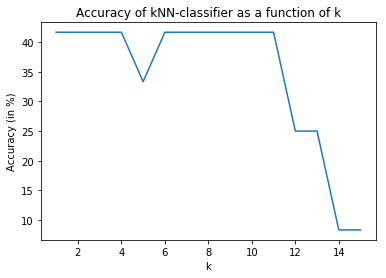

In [18]:
Accuracy_k = []
for k in range(1,16):
    Result = pd.concat([y_test, kNNpredict(X_test,k)], axis=1)
    counter = 0
    for i in Result.index:
        if Result.loc[i,"Orientation"] == Result.loc[i,"Prediction"]:
            counter +=1
    Accuracy_k.append((counter /len(Result) )*100)

plt.plot(np.arange(1,16),Accuracy_k)
plt.title('Accuracy of kNN-classifier as a function of k')
plt.xlabel('k')
plt.ylabel('Accuracy (in %)')
plt.show()

So, at its best, this kNN-classifier only does a little bit better than guessing at random ( a $33.3 \%$ chance of being correct) the side of the net I shot the ball on. Perhaps a better classifier would work here, and I could certainly but it's probably just hard in general to predict what side of the net I'm on if all I know is how many shots I made and my distance. 